In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

import dateutil.parser

In [2]:
df = pd.read_json('datascience_assignment_data.json')

In [3]:
df.head()

,distance,preorder,timestamp,tz,venue_tags,weather
0,3.123568,False,2018-04-10 09:36:53.754,{'zone': 'Europe/Helsinki'},"[sushi, japanese, gourmet]",sunny
1,2.489746,False,2018-04-10 10:27:39.279,{'zone': 'Europe/Helsinki'},"[sushi, fish]",sunny
2,1.378161,False,2018-04-10 10:35:22.101,{'zone': 'Europe/Helsinki'},"[sushi, japanese, gourmet]",sunny
3,2.390313,False,2018-04-10 12:32:17.173,{'zone': 'Europe/Helsinki'},"[sushi, fish]",sunny
4,2.493781,False,2018-04-10 13:13:56.298,{'zone': 'Europe/Helsinki'},"[sushi, japanese, gourmet]",sunny


In [4]:
#preorder is always false so we can drop it from consideration
df['preorder'].unique()

array([False])

In [5]:
df = df.drop(['preorder'], axis=1)

In [6]:
#timezone is always constant Europe/Helsinki so we can drop it from consideration
s = set( val for dic in df['tz'].values for val in dic.values())
s

{'Europe/Helsinki'}

In [7]:
df = df.drop(['tz'], axis=1)

In [8]:
#Class distribution of venue tags is highly imbalanced to a few classes so we can consider only the top 5 classes
venue_tags = df['venue_tags'].apply(pd.Series).stack().value_counts()
value_tags_names = venue_tags.index.tolist()
venue_tags

sushi          2590
japanese       2359
gourmet        2359
fresh          1130
fish            233
pita              6
lebanese          5
lunch             5
fast              5
meze              5
salad             5
sandwich          4
vegetarian        4
spicy             3
wrap              3
pizza             3
noodles           3
cheap             3
smoothie          3
asian             3
hangover          3
meat              2
meatballs         2
vietnamese        2
soup              2
american          2
italian           2
street food       1
thai              1
healthy           1
café              1
chicken           1
dessert           1
vegan             1
hamburger         1
coffee            1
artisan           1
napolese          1
fafas             1
rice              1
falafel           1
family            1
fries             1
dtype: int64

In [9]:
value_tags_names[:5]

['sushi', 'japanese', 'gourmet', 'fresh', 'fish']

In [10]:
#With weather the class distirubtion is much more even
#possible preposition to use the app more when it is raining
df['weather'].value_counts()

rain            955
sunny           740
mostly_sunny    580
overcast        332
Name: weather, dtype: int64

In [11]:
#Each day (and hour) has only one weather type
print(df.to_string())

      distance               timestamp                                         venue_tags       weather
0     3.123568 2018-04-10 09:36:53.754                         [sushi, japanese, gourmet]         sunny
1     2.489746 2018-04-10 10:27:39.279                                      [sushi, fish]         sunny
2     1.378161 2018-04-10 10:35:22.101                         [sushi, japanese, gourmet]         sunny
3     2.390313 2018-04-10 12:32:17.173                                      [sushi, fish]         sunny
4     2.493781 2018-04-10 13:13:56.298                         [sushi, japanese, gourmet]         sunny
5     2.384462 2018-04-10 13:20:33.605                                      [sushi, fish]         sunny
6     2.598420 2018-04-10 14:31:12.864                                      [sushi, fish]         sunny
7     1.343303 2018-04-10 14:50:14.454                         [sushi, japanese, gourmet]         sunny
8     2.890603 2018-04-10 17:08:15.984                         [

In [12]:
tag_df = pd.DataFrame(0, index=np.arange(len(df)), columns=value_tags_names)
venue_tags_lists = df.venue_tags.tolist()

for index, row in tag_df.iterrows():
    for tag in value_tags_names:
        if tag in venue_tags_lists[index]: 
            row[tag] = 1

In [13]:
tag_df = tag_df[['sushi', 'japanese', 'gourmet', 'fresh', 'fish']]

In [14]:
df = pd.concat([df,tag_df], axis=1)

In [15]:
df = df.drop(['venue_tags'], axis=1)

In [16]:
df.head()

,distance,timestamp,weather,sushi,japanese,gourmet,fresh,fish
0,3.123568,2018-04-10 09:36:53.754,sunny,1,1,1,0,0
1,2.489746,2018-04-10 10:27:39.279,sunny,1,0,0,0,1
2,1.378161,2018-04-10 10:35:22.101,sunny,1,1,1,0,0
3,2.390313,2018-04-10 12:32:17.173,sunny,1,0,0,0,1
4,2.493781,2018-04-10 13:13:56.298,sunny,1,1,1,0,0


In [17]:
df['weather_numeric'] = pd.Categorical(df.weather).codes

In [18]:
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.weekday
df['week'] = df['timestamp'].dt.week
df['month'] = df['timestamp'].dt.month
df.head()

,distance,timestamp,weather,sushi,japanese,gourmet,fresh,fish,weather_numeric,hour,weekday,week,month
0,3.123568,2018-04-10 09:36:53.754,sunny,1,1,1,0,0,3,9,1,15,4
1,2.489746,2018-04-10 10:27:39.279,sunny,1,0,0,0,1,3,10,1,15,4
2,1.378161,2018-04-10 10:35:22.101,sunny,1,1,1,0,0,3,10,1,15,4
3,2.390313,2018-04-10 12:32:17.173,sunny,1,0,0,0,1,3,12,1,15,4
4,2.493781,2018-04-10 13:13:56.298,sunny,1,1,1,0,0,3,13,1,15,4


## Relationship between weather and order amount

In [67]:
#Approximation on how many hours are of each weather type
hourly_sum = df.groupby([pd.Grouper(key='timestamp',freq='H'),df.weather]).size().reset_index(name='count')
hourly_sum[:10]

,timestamp,weather,count
0,2018-04-10 09:00:00,sunny,1
1,2018-04-10 10:00:00,sunny,2
2,2018-04-10 12:00:00,sunny,1
3,2018-04-10 13:00:00,sunny,2
4,2018-04-10 14:00:00,sunny,2
5,2018-04-10 17:00:00,sunny,2
6,2018-04-11 09:00:00,rain,1
7,2018-04-11 10:00:00,rain,3
8,2018-04-11 13:00:00,rain,1
9,2018-04-11 14:00:00,rain,3


In [68]:
hourly_sum_rain = hourly_sum[hourly_sum['weather'] == 'rain'].shape[0]
hourly_sum_sunny = hourly_sum[hourly_sum['weather'] == 'sunny'].shape[0]
hourly_sum_mostly_sunny = hourly_sum[hourly_sum['weather'] == 'mostly_sunny'].shape[0]
hourly_sum_overcast = hourly_sum[hourly_sum['weather'] == 'overcast'].shape[0]

In [69]:
print("orders in rain: " + str(955 / hourly_sum_rain) + " per hour")

orders in rain: 2.8851963746223563 per hour


In [70]:
print("orders in sunny: " + str(740 / hourly_sum_sunny) + " per hour")

orders in sunny: 2.364217252396166 per hour


In [71]:
print("orders in mostly sunny : " + str(580 / hourly_sum_mostly_sunny) + " per hour")

orders in mostly sunny : 2.600896860986547 per hour


In [72]:
print("orders in mostly overcast : " + str(332 / hourly_sum_overcast) + " per hour")

orders in mostly overcast : 2.8620689655172415 per hour


__Conclusion: Worse weather attracts more customers to the application__

## Relationship between time and order amount

In [57]:
#Adjust freq to W for weekly orders and M to monthly orders
daily_sum = df.groupby(pd.Grouper(key='timestamp',freq='D')).count()
daily_sum.rename(columns={'distance':'amount'}, inplace=True)

In [58]:
daily_sum.head()

,amount,weather,sushi,japanese,gourmet,fresh,fish,weather_numeric,hour,weekday,week,month
timestamp,,,,,,,,,,,,
2018-04-10,10,10,10,10,10,10,10,10,10,10,10,10
2018-04-11,12,12,12,12,12,12,12,12,12,12,12,12
2018-04-12,14,14,14,14,14,14,14,14,14,14,14,14
2018-04-13,20,20,20,20,20,20,20,20,20,20,20,20
2018-04-14,27,27,27,27,27,27,27,27,27,27,27,27


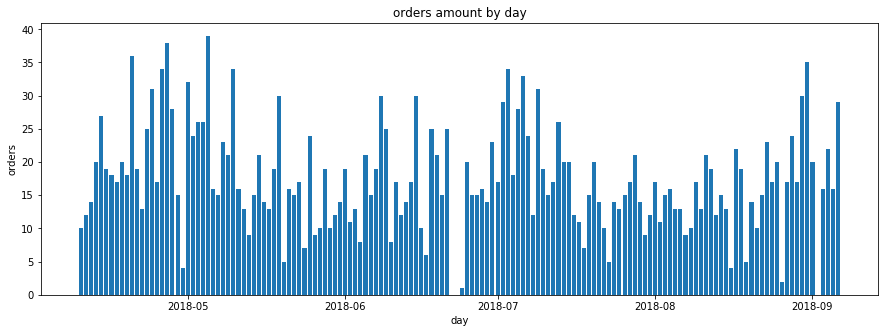

In [59]:
plt.figure(figsize=(15,5))
plt.bar(daily_sum.index, daily_sum.amount)
plt.xlabel('day')
plt.ylabel('orders')
plt.title('orders amount by day')
plt.show()

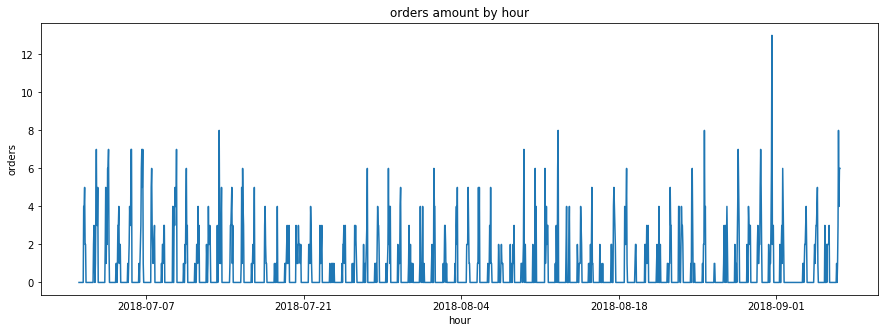

In [105]:
hourly_sum = df.groupby(pd.Grouper(key='timestamp',freq='H')).count()
hourly_sum.rename(columns={'distance':'amount'}, inplace=True)

hourly_sum = hourly_sum[hourly_sum.index > dateutil.parser.parse("2018-07-01")]
plt.figure(figsize=(15,5))
plt.plot(hourly_sum.index, hourly_sum.amount)
plt.xlabel('hour')
plt.ylabel('orders')
plt.title('orders amount by hour')
plt.show()

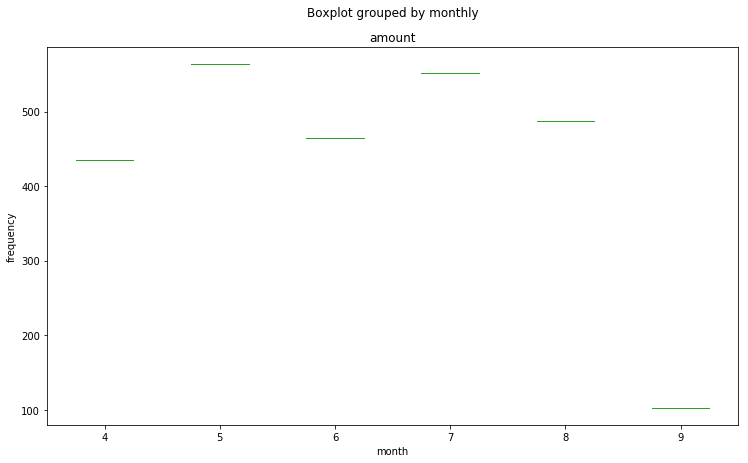

In [66]:
monthly_sum = df.groupby(pd.Grouper(key='timestamp',freq='M')).count()
monthly_sum.rename(columns={'distance':'amount'}, inplace=True)

monthly_sum['monthly'] = monthly_sum.index.month
monthly_sum.groupby(['monthly']).amount.sum()


monthly_sum.boxplot(column='amount', by='monthly', figsize=(12,7), grid=False)
plt.xlabel('month')
plt.ylabel('frequency')
plt.show()

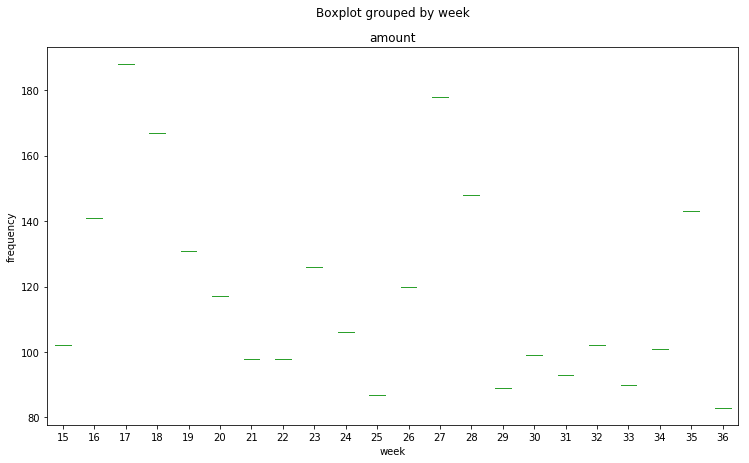

In [65]:
weekly_sum = df.groupby(pd.Grouper(key='timestamp',freq='W')).count()
weekly_sum.rename(columns={'distance':'amount'}, inplace=True)

#add day column to group_by
weekly_sum['week'] = weekly_sum.index.week

#application use increases till friday after which it decreases
weekly_sum.groupby(['week']).amount.sum()


weekly_sum.boxplot(column='amount', by='week', figsize=(12,7), grid=False)
plt.xlabel('week')
plt.ylabel('frequency')
plt.show()

C:\Users\Simo\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


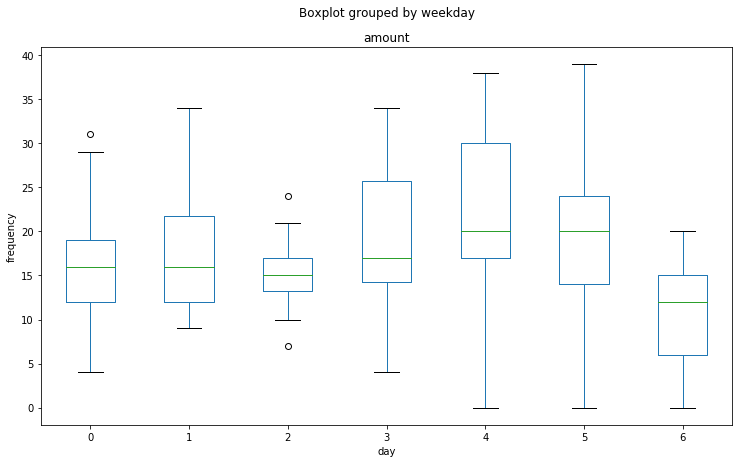

In [60]:
#add day column to group_by
daily_sum['weekday'] = daily_sum.index.weekday

#application use increases till friday after which it decreases
daily_sum.groupby(['weekday']).amount.sum()


daily_sum.boxplot(column='amount', by='weekday', figsize=(12,7), grid=False)
plt.xlabel('day')
plt.ylabel('frequency')
plt.show()

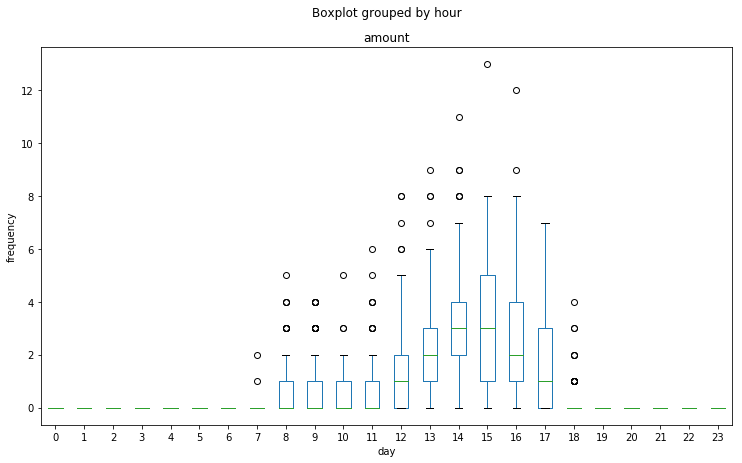

In [61]:
hourly_sum = df.groupby(pd.Grouper(key='timestamp',freq='H')).count()
hourly_sum.rename(columns={'distance':'amount'}, inplace=True)

#add day column to group_by
hourly_sum['hour'] = hourly_sum.index.hour

#application use increases till friday after which it decreases
hourly_sum.groupby(['hour']).amount.sum()


hourly_sum.boxplot(column='amount', by='hour', figsize=(12,7), grid=False)
plt.xlabel('day')
plt.ylabel('frequency')
plt.show()

## Relationship between distance and weather

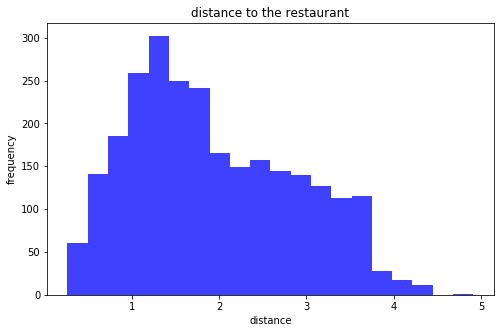

In [305]:
plt.figure(figsize=(8,5))
plt.hist(df.distance,20, facecolor='blue', alpha=0.75)
plt.xlabel('distance')
plt.ylabel('frequency')
plt.title('distance to the restaurant')
plt.show()

In [121]:
distance_weather_rain = df.loc[df['weather'] == 'rain']
distance_weather_sunny = df.loc[df['weather'] == 'sunny']
distance_weather_mostly_sunny = df.loc[df['weather'] == 'mostly_sunny']
distance_weather_overcast = df.loc[df['weather'] == 'overcast']

In [122]:
#weather does not seem to have a large effect on user distance to the restaurant 
for weather in [distance_weather_rain, distance_weather_sunny,distance_weather_mostly_sunny,distance_weather_overcast]:
    print(str(weather['weather'].iloc[0]) + " median: " + str(weather.median().distance))

rain median: 1.7960506616
sunny median: 1.76208313405
mostly_sunny median: 1.6918655821000002
overcast median: 1.80655828565


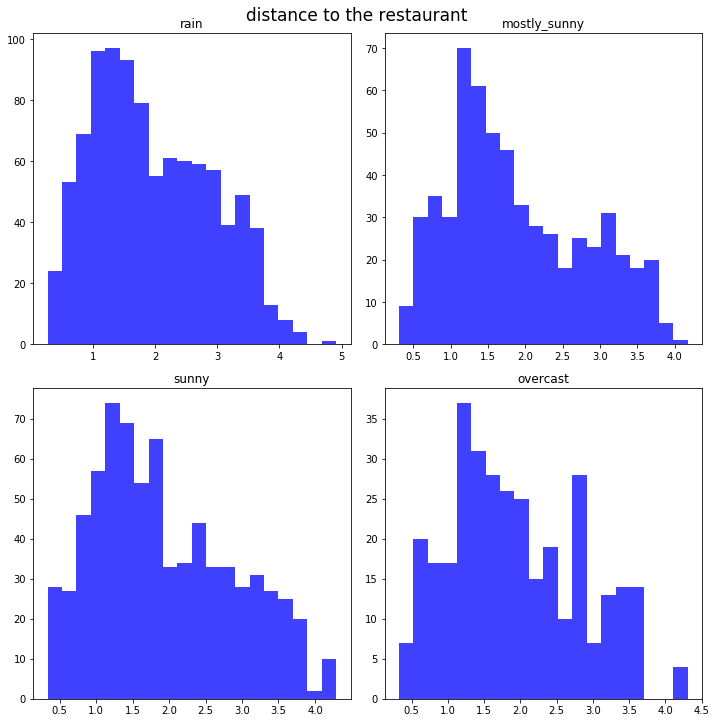

In [123]:
#This can be also seen in the histograms
fig, axs = plt.subplots(nrows=2, ncols=2, tight_layout=True,figsize=(10, 10))

# We can set the number of bins with the `bins` kwarg
axs[0,0].hist(distance_weather_rain.distance, bins=20, facecolor='blue', alpha=0.75)
axs[1,0].hist(distance_weather_sunny.distance, bins=20, facecolor='blue', alpha=0.75)
axs[0,1].hist(distance_weather_mostly_sunny.distance, bins=20, facecolor='blue', alpha=0.75)
axs[1,1].hist(distance_weather_overcast.distance, bins=20, facecolor='blue', alpha=0.75)

axs[0,0].set_title('rain')
axs[1,0].set_title('sunny')
axs[0,1].set_title('mostly_sunny')
axs[1,1].set_title('overcast')

fig.suptitle('distance to the restaurant', y=1.00, fontsize=17)

plt.show()

# Predictions for app usage

Two models are fitted: __RandomForestRegressor and an traditional ARIMAX time-series model__, whose performance is compared with MSE  and R2. 

MSE is used as larger differerences in prediction could be considered worse as opposed to MAE.

R2 is used to understand if the predictions are better than taking the mean

https://otexts.com/fpp2/accuracy.html
https://towardsdatascience.com/how-to-select-the-right-evaluation-metric-for-machine-learning-models-part-1-regrression-metrics-3606e25beae0
https://stats.stackexchange.com/questions/48267/mean-absolute-error-or-root-mean-squared-error


##  RandomForestRegressor

This model was done more as an curiosity on how to use scikit-learn to make time-series predictions and to look at how the created model compares to ARIMAX-prediction. Randomforest was used as it generally performs well across multiple task
https://machinelearningmastery.com/start-with-gradient-boosting/

Random forest could work well if the non time dependent variables ('weather') have large effect on app usage. 
https://www.quora.com/What-are-some-practical-tricks-tweeks-techniques-for-applying-random-forest-on-time-series-regression

RandomforestRegressor is used to predict average app usage amounts for future ['weather', 'hour', 'weekday'] pairs based on the averages of past pairs. Week and month are not used in the predictions as there is only a few months of data so they are always unique. Problem with the model is that it does not handle trend, but as we can see from the arima-model trend test below this is not a problem as there exist no trend.

https://stats.stackexchange.com/questions/175908/random-forest-regression-and-trended-time-series

In [ ]:
#https://medium.com/turo-engineering/how-not-to-use-random-forest-265a19a68576
#https://stats.stackexchange.com/questions/175908/random-forest-regression-and-trended-time-series
#https://www.quora.com/What-are-some-practical-tricks-tweeks-techniques-for-applying-random-forest-on-time-series-regression
#https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection
#https://machinelearningmastery.com/time-series-forecasting-performance-measures-with-python/
#https://otexts.com/fpp2/accuracy.html
#https://towardsdatascience.com/how-to-select-the-right-evaluation-metric-for-machine-learning-models-part-1-regrression-metrics-3606e25beae0

In [19]:
df.head()

,distance,timestamp,weather,sushi,japanese,gourmet,fresh,fish,weather_numeric,hour,weekday,week,month
0,3.123568,2018-04-10 09:36:53.754,sunny,1,1,1,0,0,3,9,1,15,4
1,2.489746,2018-04-10 10:27:39.279,sunny,1,0,0,0,1,3,10,1,15,4
2,1.378161,2018-04-10 10:35:22.101,sunny,1,1,1,0,0,3,10,1,15,4
3,2.390313,2018-04-10 12:32:17.173,sunny,1,0,0,0,1,3,12,1,15,4
4,2.493781,2018-04-10 13:13:56.298,sunny,1,1,1,0,0,3,13,1,15,4


In [147]:
df_train = df[df['month'] < 7]
df_test = df[df['month'] >= 7]

In [148]:
display(df_train.shape)
display(df_test.shape)


(1464, 13)

(1143, 13)

In [149]:
df_train_amount = df_train[['weather_numeric', 'hour', 'weekday', 'week', 'month']]
df_test_amount = df_test[['weather_numeric', 'hour', 'weekday', 'week', 'month']]

df_train_amount = df_train_amount.groupby(df_train_amount.columns.tolist()).size().reset_index().\
    rename(columns={0:'amount'})

df_test_amount = df_test_amount.groupby(df_test_amount.columns.tolist()).size().reset_index().\
    rename(columns={0:'amount'})

df_train_amount.head()

,weather_numeric,hour,weekday,week,month,amount
0,0,8,0,16,4,4
1,0,8,0,17,4,3
2,0,8,0,19,5,1
3,0,8,0,21,5,1
4,0,8,2,16,4,2


In [89]:
display(df_train_amount.shape)
display(df_test_amount.shape)

(534, 6)

(449, 6)

In [191]:
#week and month not considered as they are alkways unique
X_train = df_train_amount[['weather_numeric', 'hour', 'weekday']]
X_test = df_test_amount[['weather_numeric', 'hour', 'weekday']]

y_train = df_train_amount.amount
y_test = df_test_amount.amount

In [168]:
from sklearn.model_selection import GridSearchCV

grid = {'n_estimators': [20,50,100,200],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [2,3,4,5],
               'min_samples_split': [2,3,4,5],
               'min_samples_leaf': [1,2,4,5]}


#https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection
#https://medium.com/cindicator/backtesting-time-series-models-weekend-of-a-data-scientist-92079cc2c540
#This would be a wrong 

rf = RandomForestRegressor(random_state=123)
rf_cv = GridSearchCV(estimator = rf, param_grid = grid, cv = 5,scoring='neg_mean_squared_error',
                     verbose=1, n_jobs = 4)
rf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  65 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 665 tasks      | elapsed:   12.0s
[Parallel(n_jobs=4)]: Done 1665 tasks      | elapsed:   28.4s
[Parallel(n_jobs=4)]: Done 2553 out of 2560 | elapsed:   43.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 2560 out of 2560 | elapsed:   43.8s finished
C:\Users\Simo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=123, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'n_estimators': [20, 50, 100, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5], 'min_samples_leaf': [1, 2, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [169]:
rf_cv.best_params_

{'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 20}

In [170]:
#negative MSE
rf_cv.score(X_train, y_train)

-2.823829688648262

In [171]:
rf = RandomForestRegressor(n_estimators= 20, min_samples_split= 2, 
                           min_samples_leaf=5, max_features='sqrt', max_depth=4, criterion='mse',random_state=123)
rf.fit(X_train, y_train)

display('train r2  %f' % rf.score(X_train, y_train))


mse = mean_absolute_error(rf.predict(X_train), y_train)
display('train MSE: %f' % mse)


display('test (foreast) r2  %f' % rf.score(X_test, y_test))

#mse test (forecast)
mse = mean_squared_error(rf.predict(X_test), y_test)
display('test (forecast)  MSE: %f' % mse)

'train r2  0.258763'

'train MSE: 1.282720'

'test (foreast) r2  0.136150'

'test (forecast)  MSE: 2.507500'

In [172]:
#Most important features
#1. hour
#2. day
#3. weather numeric
print(rf.feature_importances_)

[0.10296834 0.65936399 0.23766767]


__We can see visually that the model produces quite good averages of orders per hour__ 

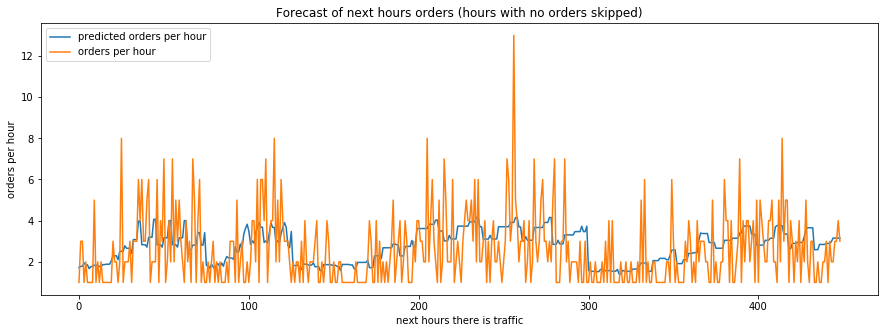

In [173]:
x = rf.predict(X_test)

plt.figure(figsize=(15,5))

plt.plot(np.arange(len(x)), x,label="predicted orders per hour")
plt.plot(np.arange(len(x)), y_test, label="orders per hour")
plt.legend(loc='upper left')
plt.xlabel('next hours there is traffic')
plt.ylabel('orders per hour')
plt.title('Forecast of next hours orders (hours with no orders skipped)')

plt.show()

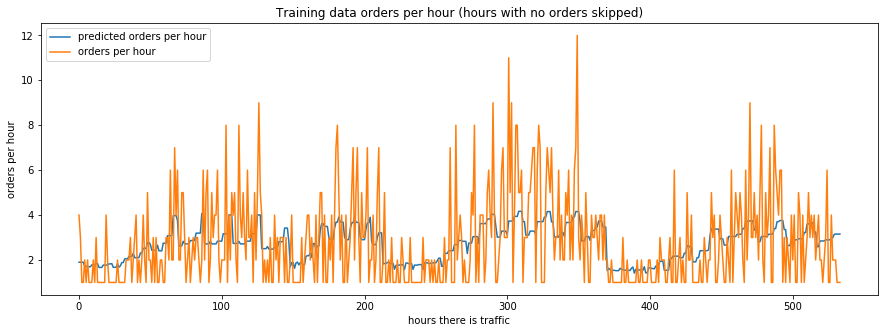

In [174]:
x = rf.predict(X_train)

plt.figure(figsize=(15,5))

plt.plot(np.arange(len(x)), x,label="predicted orders per hour")
plt.plot(np.arange(len(x)), y_train, label="orders per hour")
plt.legend(loc='upper left')
plt.xlabel('hours there is traffic')
plt.ylabel('orders per hour')
plt.title('Training data orders per hour (hours with no orders skipped)')

plt.show()

In [194]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)
#mean_absolute_error(reg.predict(X_train), y_train)
#mean_absolute_error(reg.predict(X_test), y_test)
reg.score(X_test, y_test)

1.2995959466083136

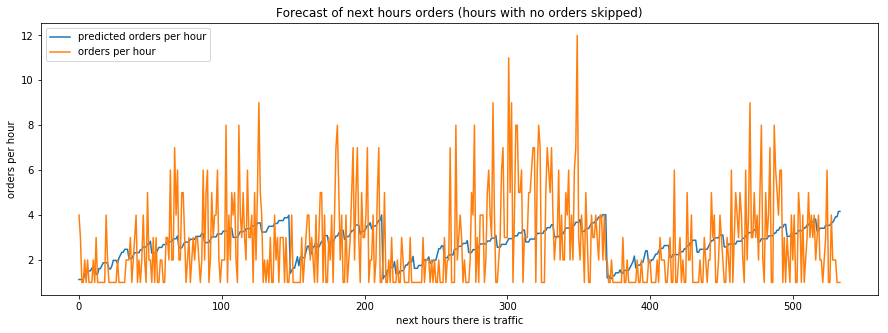

In [196]:
reg = LinearRegression().fit(X_train, y_train)

x = reg.predict(X_train)

plt.figure(figsize=(15,5))

plt.plot(np.arange(len(x)), x,label="predicted orders per hour")
plt.plot(np.arange(len(x)), y_train, label="orders per hour")
plt.legend(loc='upper left')
plt.xlabel('next hours there is traffic')
plt.ylabel('orders per hour')
plt.title('Forecast of next hours orders (hours with no orders skipped)')

plt.show()

## ARIMAX time-series model

In [110]:
hourly_sum = df.groupby(pd.Grouper(key='timestamp',freq='H')).count()
hourly_sum.rename(columns={'distance':'amount'}, inplace=True)
hourly_sum = hourly_sum[['amount']]

In [115]:
arimax_train = hourly_sum[hourly_sum.index < dateutil.parser.parse("2018-07-01")]
arimax_test = hourly_sum[hourly_sum.index > dateutil.parser.parse("2018-07-01")]

display(arimax_train.shape)
display(arimax_test.shape)

(1959, 1)

(1624, 1)

In [117]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

__Checck the time-series for stationarity__

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [118]:
res = sm.tsa.adfuller(arimax_train.amount,regression='ct')
display('ct: p-value:{}'.format(res[1]))

res = sm.tsa.adfuller(arimax_train.amount,regression='c')
display('c: p-value:{}'.format(res[1]))


'ct: p-value:2.4886045638596997e-07'

'c: p-value:1.7220097176860894e-07'

__Checck the time-series for seasonality__

Clear 24 hour seasonal component as shown from the decomposition and autocorrelation functions

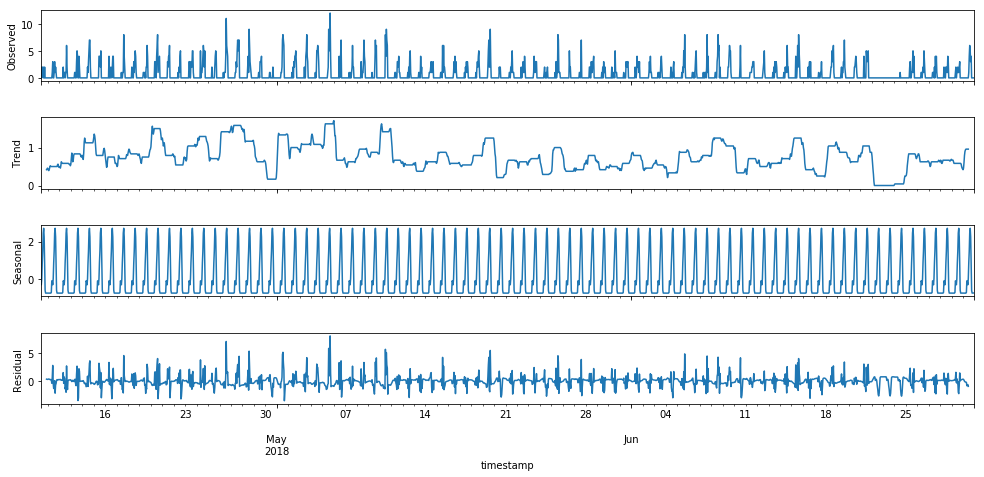

In [121]:
decomposition = sm.tsa.seasonal_decompose(arimax_train.amount)
resplot = decomposition.plot()
resplot.set_figheight(8)
resplot.set_figwidth(15)

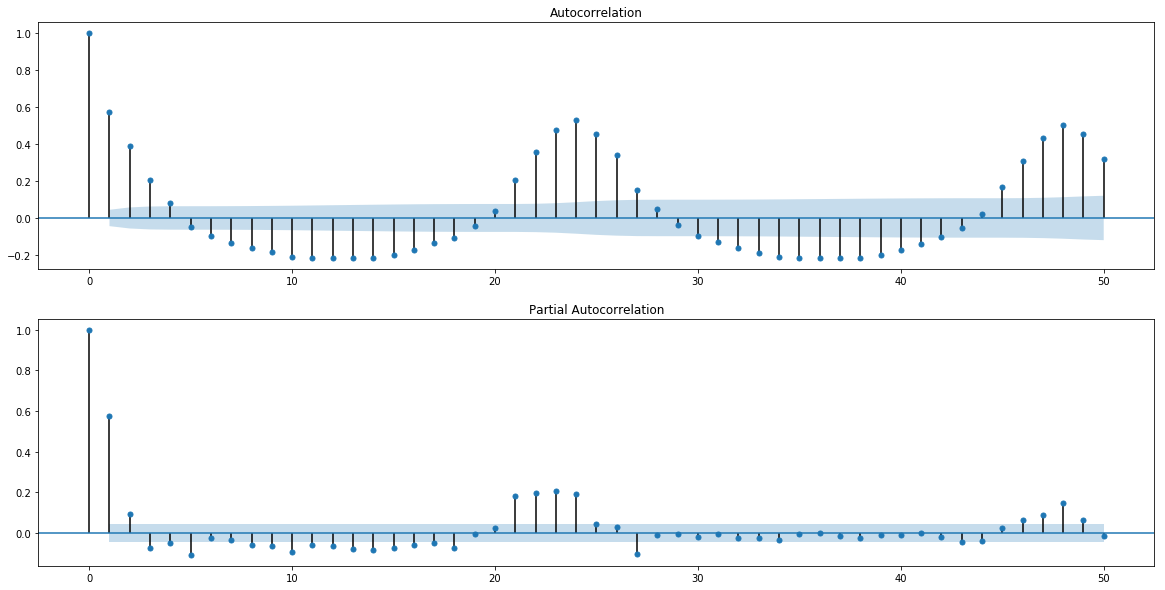

In [122]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(arimax_train.amount, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(arimax_train.amount, lags=50, ax=ax[1])
plt.show()

__best arimax model parameters with auto arima__

Best model: SARIMAX(2, 1, 1)x(0, 1, 2, 24)

In [123]:
stepwise_fit = pm.auto_arima(arimax_train.amount, start_p=1, start_q=1, max_p=3, max_q=3, m=24,
                            seasonal=True, d=1, D=1, trace=True,
                            error_action='ignore',  # don't want to know if an order does not work
                            suppress_warnings=True,  # don't want convergence warnings
                            stepwise=True)  # set to stepwise
stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 24); AIC=5953.147, BIC=5986.551, Fit time=68.365 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 24); AIC=8001.628, BIC=8012.762, Fit time=0.657 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 24); AIC=7090.554, BIC=7112.824, Fit time=6.759 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 24); AIC=6076.441, BIC=6098.711, Fit time=50.755 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 24); AIC=5958.905, BIC=5986.741, Fit time=86.541 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 1, 24); AIC=5968.001, BIC=6006.972, Fit time=178.150 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 24); AIC=6559.545, BIC=6587.382, Fit time=56.692 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 24); AIC=5956.940, BIC=5995.911, Fit time=198.784 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 24); AIC=7058.881, BIC=7081.151, Fit time=19.441 seconds
Fit ARIMA: order=(1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1959
Model:             SARIMAX(2, 1, 1)x(0, 1, 2, 24)   Log Likelihood               -2965.557
Date:                            Wed, 06 Mar 2019   AIC                           5945.113
Time:                                    15:09:45   BIC                           5984.084
Sample:                                         0   HQIC                          5959.447
                                           - 1959                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -9.977e-06   1.65e-05     -0.605      0.545   -4.23e-05    2.23e-05
ar.L1          0.2380      0.014     16.906      0.000       0.210       0.266
ar.L2          0.0858      0.015      5.600      0.000       0.056       0.116
ma.L1         -0.9900      0.006   -174.320      0.000      -1.001      -0.979
ma.S.L24      -0.9454      0.057    -16.614      0.000      -1.057      -0.834
ma.S.L48      -0.0516      0.015     -3.366      0.001      -0.082      -0.022
sigma2         1.1780      0.070     16.942      0.000       1.042       1.314
===================================================================================
Ljung-Box (Q):                       51.84   Jarque-Bera (JB):              5591.18
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                             1.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [132]:
sarima = sm.tsa.statespace.SARIMAX(arimax_train.amount,order=(2,1,1),seasonal_order=(0,1,2,24),
                                 enforce_stationarity=False, enforce_invertibility=False).fit()

sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             amount   No. Observations:                 1959
Model:             SARIMAX(2, 1, 1)x(0, 1, 2, 24)   Log Likelihood               -2884.457
Date:                            Wed, 06 Mar 2019   AIC                           5780.914
Time:                                    15:28:23   BIC                           5814.160
Sample:                                04-10-2018   HQIC                          5793.158
                                     - 06-30-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2395      0.014     17.182      0.000       0.212       0.267
ar.L2          0.0817      0.015      5.364      0.000       0.052       0.112
ma.L1         -1.0037      0.004   -255.824      0.000      -1.011      -0.996
ma.S.L24      -0.9354      0.014    -65.484      0.000      -0.963      -0.907
ma.S.L48      -0.0416      0.014     -3.027      0.002      -0.069      -0.015
sigma2         1.2009      0.021     58.408      0.000       1.161       1.241
===================================================================================
Ljung-Box (Q):                       43.65   Jarque-Bera (JB):              5289.68
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                             1.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [136]:
pred = sarima.predict(1959 + 1,1959 + 1624)

ARIMAX model MSE:1.1734172536255787
ARIMAX model R2:0.44092436302112137


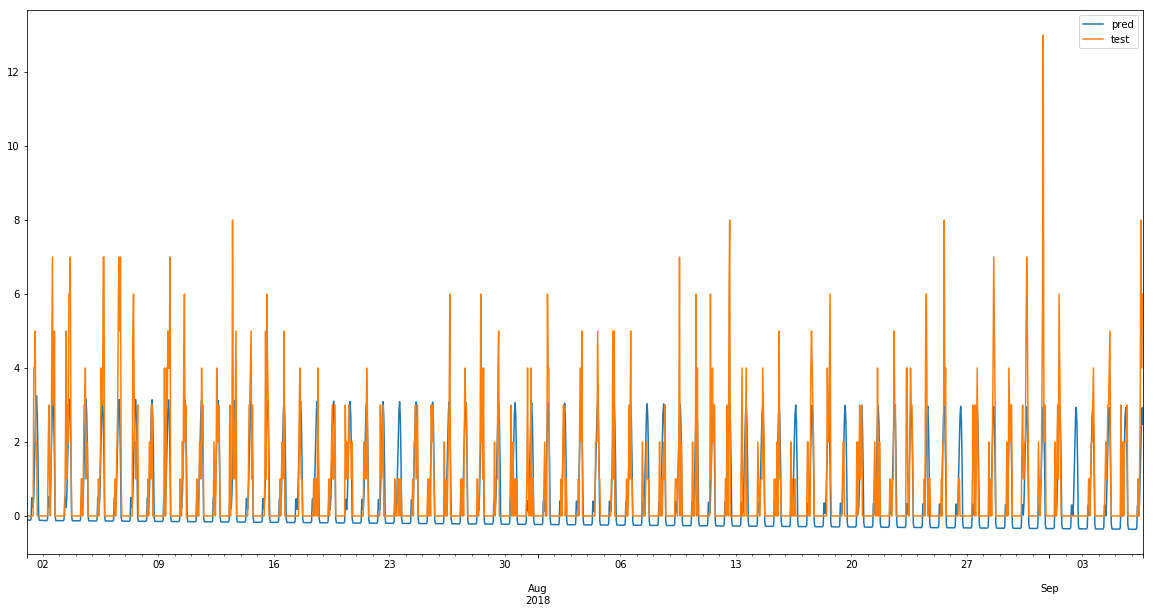

In [175]:
print('ARIMAX model MSE:{}'.format(mean_squared_error(arimax_test,pred)))
print('ARIMAX model R2:{}'.format(r2_score(arimax_test,pred)))

pd.DataFrame({'test':arimax_test.values.flatten(),'pred':pred}).plot(figsize=(20,10));plt.show()

In [185]:
pred_hours_remove = pred.between_time('08:00:00', '18:00:00')#pred[pred.index < '08:00:00']
arimax_test_hours_remove = arimax_test.between_time('08:00:00', '18:00:00')#

__By removing the hours, which there is no data of we can better compare the two models, expectedly the performance decreases__


ARIMAX model MSE:2.4821556591008487
ARIMAX model R2:0.24780958317918567


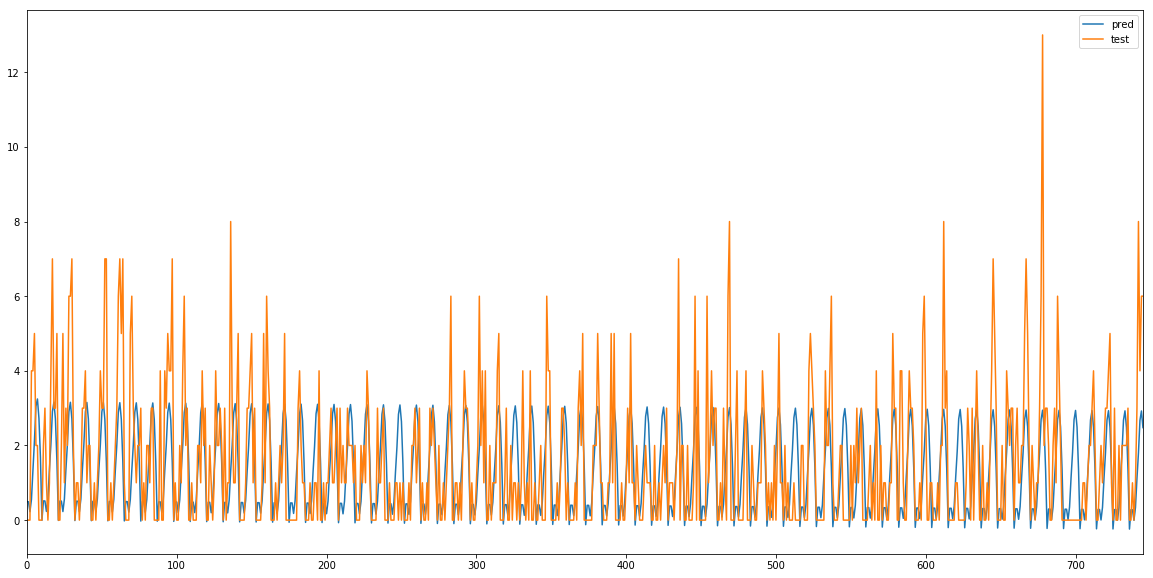

In [190]:
print('ARIMAX model MSE:{}'.format(mean_squared_error(arimax_test_hours_remove,pred_hours_remove)))
print('ARIMAX model R2:{}'.format(r2_score(arimax_test_hours_remove,pred_hours_remove)))

pd.DataFrame({'test':arimax_test_hours_remove.values.flatten(),'pred':pred_hours_remove.values.flatten()}).plot(figsize=(20,10));plt.show()